In [1]:
#import packages
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# read in the dataframe from the csv file
file = r"C:\Users\Home\Documents\Atom Files\Wikipedia-Traffic-Time-Series\data\train_data\train_1.csv"
data = pd.read_csv(file)
df = data.copy(deep=True)

In [3]:
df = df.fillna(0) # fill na just for our intial look
df.head(5)

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


split our time series into train test so we can multi-step forcast

In [4]:
# import packages
import numpy as np
from fbprophet import Prophet
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [5]:
# get our data and some info about it
row = 25
test_size = 60
values = df.loc[[row]].values[0][1:]
train, test = values[0:-(test_size)], values[-(test_size):]

In [6]:
def holts_method(seasonal_periods, trend, seasonal):
    """
    Holts-Winters method using Exponential Smoothing
    """
    model = ExponentialSmoothing(train, seasonal_periods=seasonal_periods, trend=trend, seasonal=seasonal).fit()
    return model
    
def ARMA_model(order):
    """
    Autoregression Moving Average
    """
    model = ARMA(train, order).fit(disp=-1)
    return model

def SARIMAX_model(order, seasonal_order):
    """
    Seasonal Autoregression Integrated Moving Average (eXogenous)
    """
    model = SARIMAX(train.astype(np.int64), order=order, seasonal_order=seasonal_order).fit(disp=-1)
    return model


In [7]:
def root_mean_squared_error(predicted):
    sum_error = 0.0
    for i in range(len(test)):
        prediction_error = predicted[i] - test[i]
        sum_error += (prediction_error ** 2)
    mean_error = sum_error / float(len(test))
    return mean_error**.5

def plot_all(models, zoom):
    # visual for statsmodel's Autoregression methods
    pred_h = models['HoltsWinter'].predict(len(train), len(train) + len(test) - 1)
    pred_a = models['ARMA'].predict(len(train), len(train) + len(test) - 1)
    pred_s = models['SARIMAX'].predict(len(train), len(train) + len(test) - 1)
    
    plt.style.use('seaborn-dark')
    fig = plt.figure(figsize=(35, 20))
    
    if not zoom:
        plt.plot(range(-len(train), 0), train, label='Train', color = 'blue')
        plt.plot(range(-len(train), 0), models['HoltsWinter'].fittedvalues, color='red', label='Fitted Holts: %f' % (root_mean_squared_error(models['HoltsWinter'].fittedvalues)))
        plt.plot(range(-len(train), 0), models['ARMA'].fittedvalues, color='yellow', label='Fitted ARMA: %f' % (root_mean_squared_error(models['ARMA'].fittedvalues)))
        plt.plot(range(-len(train), 0), models['SARIMAX'].fittedvalues, color='green', label='Fitted SAIRMAX: %f' % (root_mean_squared_error(models['SARIMAX'].fittedvalues)))

    plt.plot(test, linestyle="--", label='True Test', color = 'blue')
    plt.plot(pred_h, color='red', label='Preds Holt: %f' % (root_mean_squared_error(pred_h)))
    plt.plot(pred_a, color='yellow', label='Preds ARMA: %f' % (root_mean_squared_error(pred_a)))
    plt.plot(pred_s, color='green', label='Preds SAIRMAX: %f' % (root_mean_squared_error(pred_s)))

    plt.legend(loc='best', fontsize = 'xx-large')
    plt.show()


from our corrlation plots we saw 10,4 seaonsal ...

C:\Users\Home\.conda\envs\DS\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Home\.conda\envs\DS\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


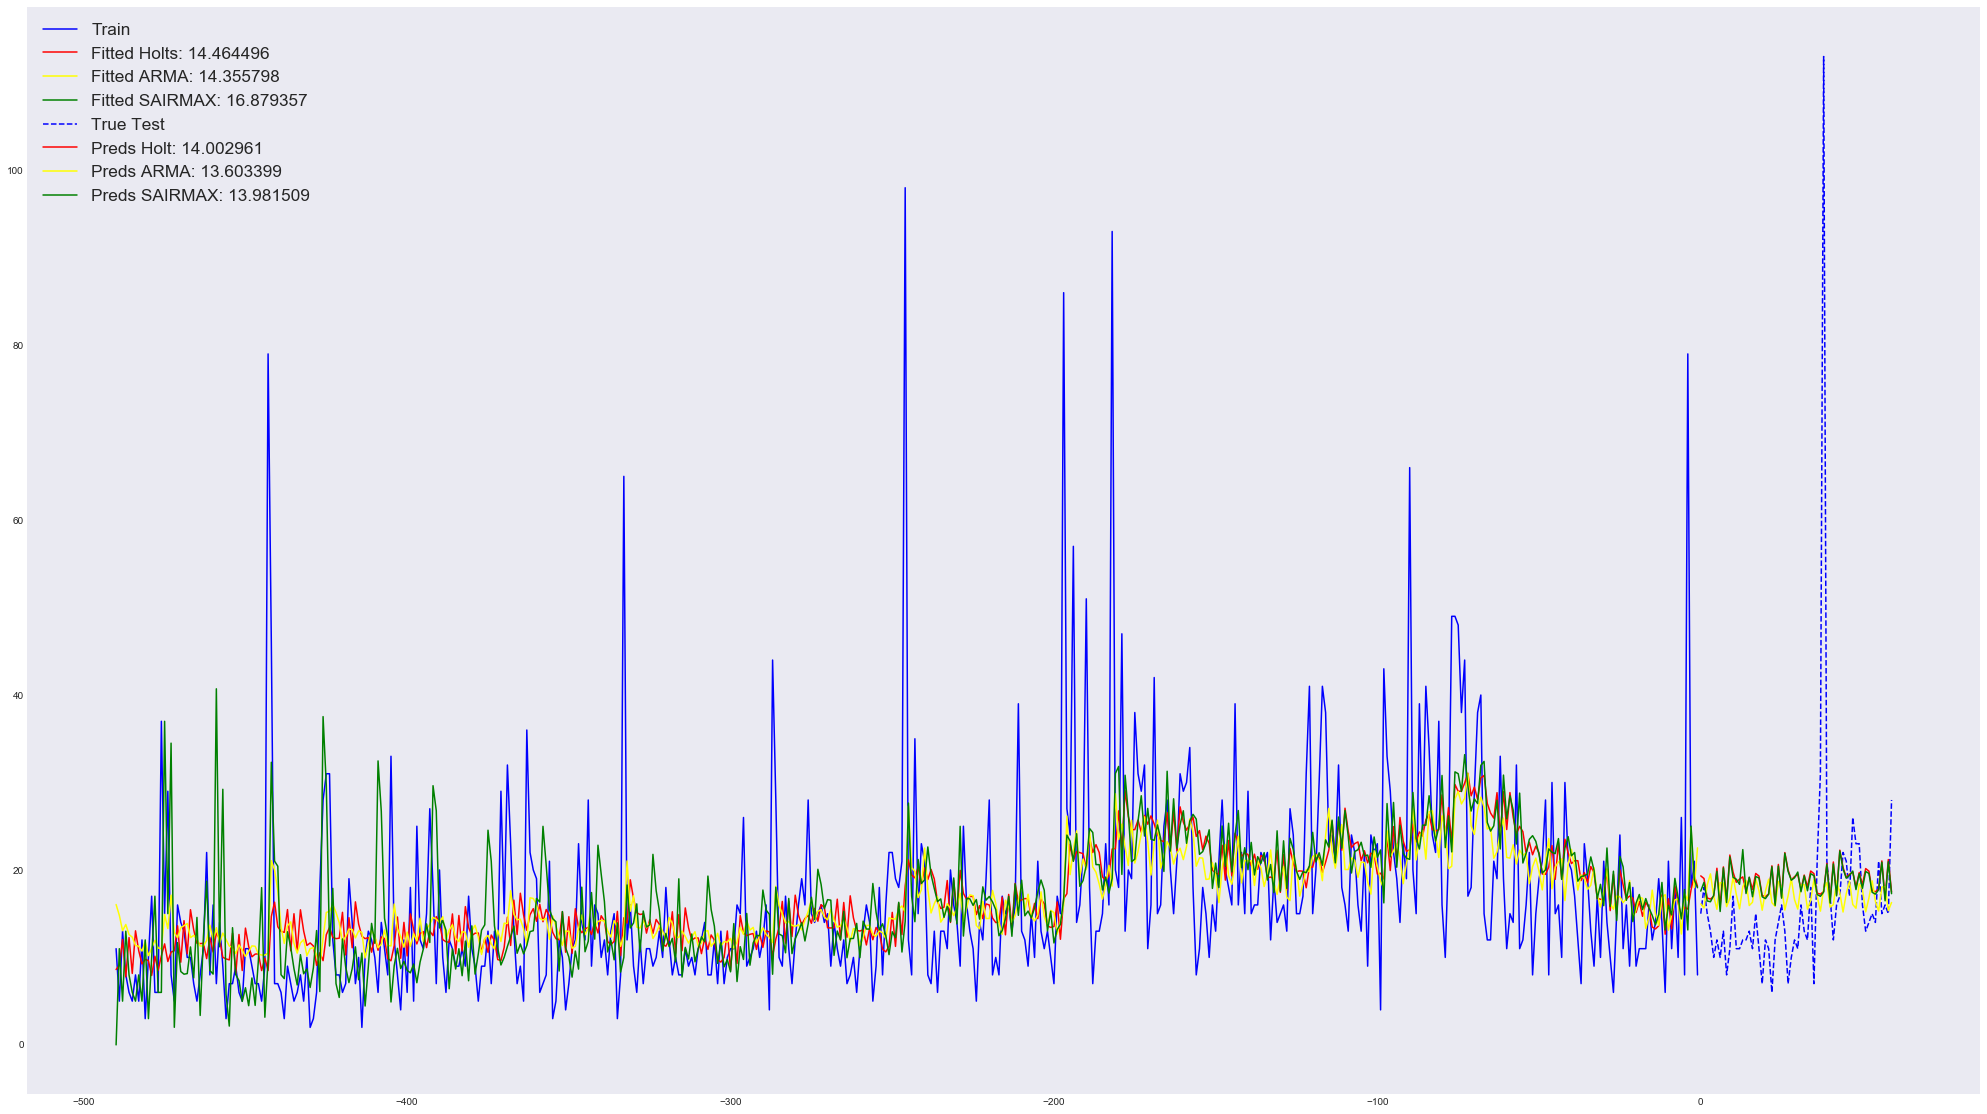

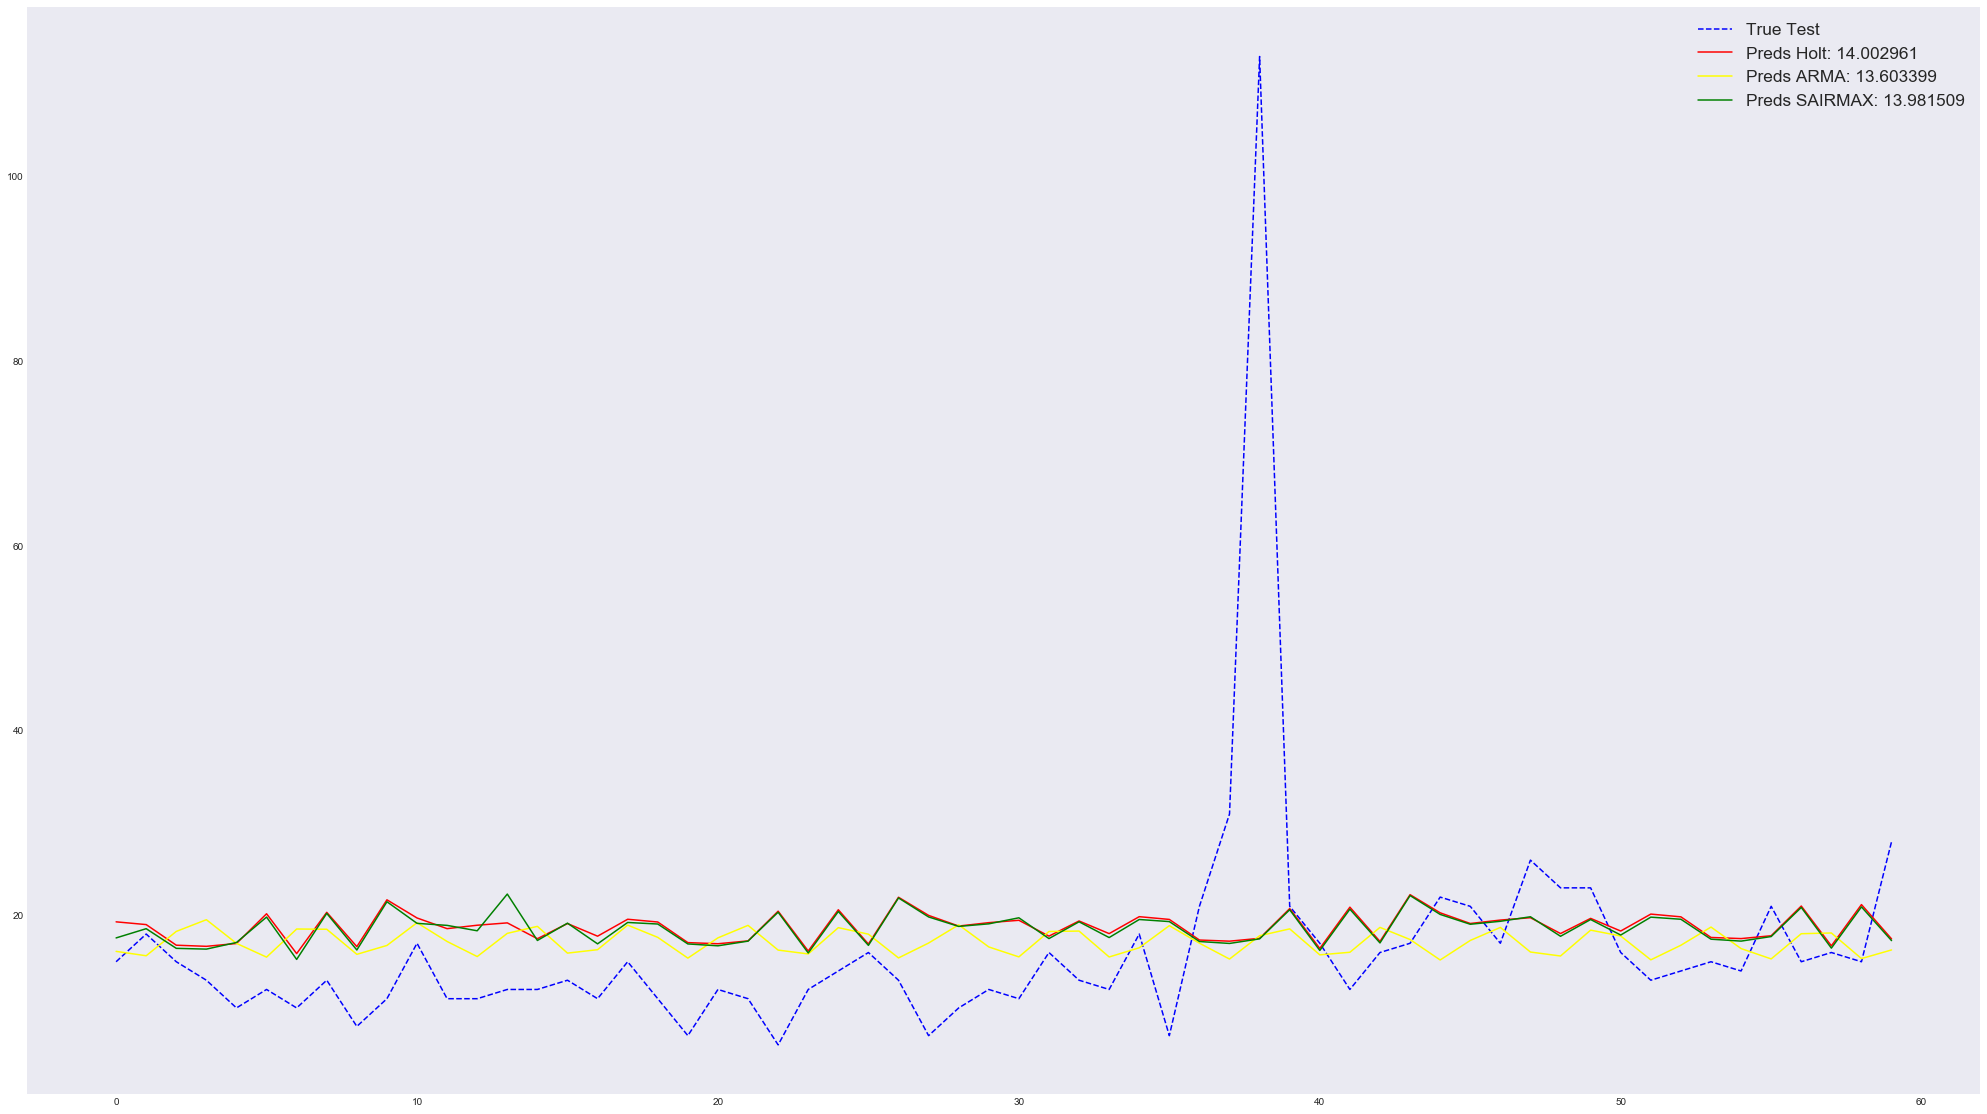

In [8]:
models = {'HoltsWinter':holts_method(seasonal_periods=17, trend='add', seasonal='add'),
          'ARMA':ARMA_model(order=(10,4)),
          'SARIMAX':SARIMAX_model(order=(1,1,1), seasonal_order=(1,1,1,17))}

plot_all(models, zoom = False)
plot_all(models, zoom = True)


facebook's prophet is very good at handling x y z. Provides forcasting visualize natively with confidence bands. 

In [9]:
def prohpet(dataframe, row):
    """
    Facebook's Prophet
    """
    # prohpet preprocess
    dfp = dataframe.drop(columns='Page')
    dfp = dfp.transpose()
    dfp.index = pd.to_datetime(dfp.index)
    dfp['ds'] = dfp.index
    dfp['y'] = dfp[row]
    prophet_df = dfp[['ds', 'y']].iloc[:-(test_size)]
    
    # prohpet
    m = Prophet()
    m.fit(prophet_df)
    future = m.make_future_dataframe(periods=test_size, freq='D')
    forecast = m.predict(future)
    m.plot(forecast)
    
    return forecast


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Home\.conda\envs\DS\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Preds Prohpet: 14.596047


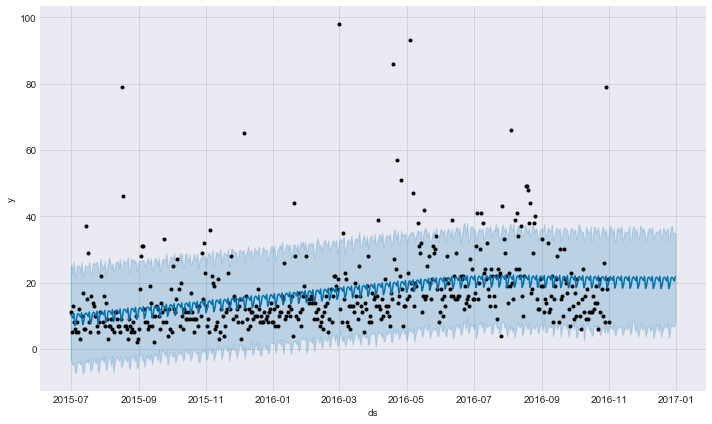

In [10]:
forecast = prohpet(df, 25)
print("Preds Prohpet: %f" % root_mean_squared_error(forecast['yhat'].values))